# Intro to Normalizing Flows for Physics Applications
- Octavio Vega [octavio5@illinois.edu]
- Adapted from: [Shanahan, et al. arXiv:2101.08176]

# Part 0: Setup and Utilities

(You can safely just run these cells and move on to Part 1.)

In [1]:
# Import some necessary libraries
import numpy as np
import torch

import typing as t
import numpy.typing as npt

import io
import pickle
import base64

if __name__ == '__main__':
    print('TORCH VERSION:', torch.__version__)
    import packaging.version
    if packaging.version.parse(torch.__version__) < packaging.version.parse('1.5.0'):
        raise RuntimeError('Torch versions lower than 1.5.0 not suported')
    
# Set plotting style preferences
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

if __name__ == '__main__':
    plt.rc('text', usetex=True)
    plt.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
    
    font = {
        'weight' : 'normal',
        'size'   : 18
    }
    mpl.rc('font', **font)    
    mpl.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'  # \text

    sns.set_style('whitegrid')

TORCH VERSION: 2.3.1+cpu


In [2]:
# Set device for PyTorch
_DEFAULT_DEVICE: str = 'cpu'

def set_torch_device() -> tuple[str, npt.DTypeLike]:
    """
    Initializes torch device for experiments.

    If running on GPU, use `float32` precision for increased memory bandwidth.
    """
    global _DEFAULT_DEVICE
    if torch.cuda.is_available():
        torch_device = 'cuda'
        float_dtype = np.float32  # single prec
        torch.set_default_tensor_type(torch.cuda.FloatTensor)
    else:
        torch_device = _DEFAULT_DEVICE
        float_dtype = np.float64  # double prec
        torch.set_default_tensor_type(torch.DoubleTensor)
    print('Device inited:', torch_device)
    return torch_device, float_dtype

torch_device, float_dtype = set_torch_device()

Device inited: cpu


C:\Users\vega0\AppData\Roaming\Python\Python310\site-packages\torch\__init__.py:749: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ..\torch\csrc\tensor\python_tensor.cpp:433.)
  _C._set_default_tensor_type(t)


In [3]:
# For real time display of training
class TrainingPlot(plt.Figure):
    """
    Live, updating plot for visualization of metrics during training.
    
    Args:
        num_eras: Number of eras for training
        num_epochs: Number of epochs per era
        dpi: Output figure resolution; default 200
        figsize: Tuple of figure (width, height); default (8, 4)

    Attributes:
        fig: The figure to be output
        fig_dict: Dictionary of axis info and corresponding lines
    """
    @staticmethod
    def moving_average(
        x: npt.ArrayLike, 
        width: t.Optional[int] = 10
    ) -> npt.NDArray:
        """
        Moving average over a window of length specified by `width`.
        
        Args:
            x: Data
            width: Window length
            
        Returns:
            Moving averaged `x` over `width`.
        """
        if len(x) < width:
            return np.mean(x, keepdims=True)
        else:
            return np.convolve(x, np.ones(width), 'valid') / width
    
    def __init__(self, 
        num_eras: int, 
        num_epochs: int, 
        dpi: t.Optional[int] = 200, 
        figsize: t.Optional[tuple[int]] = (8, 4)
    ):
        super().__init__()

        fig, ax_ess = plt.subplots(1, 1, dpi=dpi, figsize=figsize)
        plt.xlim(0, num_eras * num_epochs)
        plt.ylim(0, 1)
        plt.xlabel('Training Steps')

        ess_line = plt.plot([0], [0], alpha=0.5)
        plt.grid(False)
        plt.ylabel('ESS')

        ax_loss = ax_ess.twinx()
        loss_line = plt.plot([0], [0], alpha=0.5, c='orange')
        plt.grid(False)
        plt.ylabel('Loss')

        display_id = display(fig, display_id=True)

        self.fig = fig
        self.fig_dict = dict(
            ax_ess=ax_ess, ax_loss=ax_loss,
            ess_line=ess_line, loss_line=loss_line,
            display_id=display_id
        )

    def update(self, history, ax_ess, ax_loss, ess_line, loss_line, display_id):
        Y = np.array(history['ess'])
        Y = TrainingPlot.moving_average(Y, width=15)
        ess_line[0].set_ydata(Y)
        ess_line[0].set_xdata(np.arange(len(Y)))
        
        Y = history['loss']
        Y = TrainingPlot.moving_average(Y, width=15)
        loss_line[0].set_ydata(np.array(Y))
        loss_line[0].set_xdata(np.arange(len(Y)))
        
        _ = ax_ess  # unused
        ax_loss.relim()
        ax_loss.autoscale_view()
        self.fig.canvas.draw()
        display_id.update(self.fig)  # need to force colab to update plot

In [4]:
# Some additional utilities
def grab(tensor: torch.Tensor) -> npt.NDArray:
    """
    Detaches tensors from computational graph and pulls them into the CPU as 
    ordinary `numpy` arrays.
    
    Args:
        tensor: PyTorch `Tensor` object

    Returns:
        Tensor converted to `numpy` array in local memory.
    """
    return tensor.detach().cpu().numpy()

# Part 1: A Simple Example

Suppose we are given random vectors $u_1, u_2 \sim {\rm Unif}(0, 1)$. Consider 
the Box-Muller Transform:
$$\left(u_1, u_2\right) \mapsto \left(z_1, z_2\right) = \sqrt{-2 \ln u_1}\left(\cos(2\pi u_2), \sin(2\pi u_2)\right)$$

In [5]:
# Get uniform samples
batch_size = 2**14
u = np.random.random(size=(batch_size, 2))

def box_muller(u: npt.NDArray) -> npt.NDArray:
    """
    Applies Box-Muller transform to batch of random vectors. Assumes `u` has 
    shape `[batch_size, num_features]`.
    """
    u1, u2 = u[:, 0], u[:, 1]
    
    prefactor = np.sqrt(-2 * np.log(u1))[:, np.newaxis]
    z = np.stack(
        (np.cos(2 * np.pi * u2), np.sin(2 * np.pi * u2)), axis=-1
    )
    return prefactor * z

# Transform the uniform samples
z = box_muller(u)

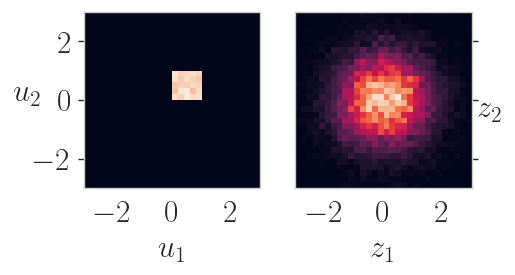

In [6]:
# Visualize the transformation
fig, ax = plt.subplots(1, 2, dpi=125, figsize=(4, 2))
for a in ax:
    a.set_xticks([-2, 0, 2])
    a.set_yticks([-2, 0, 2])
    a.set_aspect('equal')

ax[0].hist2d(u[:,0], u[:,1], bins=30, range=[[-3.0,3.0], [-3.0,3.0]])
ax[0].set_xlabel(r"$u_1$")
ax[0].set_ylabel(r"$u_2$", rotation=0, y=.46)
ax[0].yaxis.tick_left()

ax[1].hist2d(z[:,0], z[:,1], bins=30, range=[[-3.0,3.0], [-3.0,3.0]])
ax[1].set_yticklabels([])
ax[1].set_xlabel(r"$z_1$")
ax[1].set_ylabel(r"$z_2$", rotation=0, y=.53)
ax[1].yaxis.set_label_position("right")
ax[1].yaxis.tick_right()

plt.show()

# Part 2: A General Example

In [7]:
# Contstruct a simple prior that is easily sampleable and has calculable density
class SimpleNormalPrior:
    """
    Simple Normal distribution. Shaping is handled more robustly than in
    `torch.distributions`.

    Args:
        mean: Mean of the distribution; the shape of `mean` defines the shape
            of the prior samples
        var: Variance of the distributoin

    Attributes:
        dist: Distribution defining the prior
        shape: Shape of data samples, ignoring the batch dimension
    """
    def __init__(self, 
        mean: torch.Tensor, 
        var: torch.Tensor
    ):
        self.dist = torch.distributions.normal.Normal(
            loc = torch.flatten(mean),
            scale = torch.flatten(var)
        )
        self.shape = mean.shape

    def log_prob(self, x: torch.Tensor):
        """Computes the log likelihood of a batch of samples `x`."""
        logp = self.dist.log_prob(x.reshape(x.shape[0], -1))
        return torch.sum(logp, dim=1)
    
    def sample(self, batch_size: int):
        """Generates `batch_size` many samples from the prior dist."""
        x = self.dist.sample(sample_shape=(batch_size,))
        return x.reshape(batch_size, *self.shape)
    

normal_prior = SimpleNormalPrior(
    mean=torch.zeros((3, 4, 5)), 
    var=torch.ones((3, 4, 5))
)
z = normal_prior.sample(16)
print('z.shape =', z.shape)
print('log r(z) = ', grab(normal_prior.log_prob(z)))

z.shape = torch.Size([16, 3, 4, 5])
log r(z) =  [ -89.87033633  -88.39512077  -87.66284262 -100.10256616  -82.52316882
  -92.77209626  -87.34981011  -89.3705331   -84.4504338   -78.06805759
  -91.02831205  -80.3602573   -84.61319566  -83.16247514  -76.75095192
  -95.44638456]


In [8]:
# Abstract coupling layer object
class CouplingLayer(torch.nn.Module):
    """
    Differentiable, bijective transformation g: D -> D from data domain into
    data domain. 

    Abstract base class.
    """
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward transformation."""
        raise NotImplementedError('Coupling layer must override forward call.')
    
    def reverse(self, fx: torch.Tensor) -> torch.Tensor:
        """Inverse transformation."""
        raise NotImplementedError('Coupling layer must override reverse call.')


# Define a simple affine coupling layer
class SimpleCoupling(CouplingLayer):
    """A simple example of the affine coupling layer."""
    def __init__(self):
        super().__init__()

        self.s = torch.nn.Sequential(
            torch.nn.Linear(1, 8),
            torch.nn.ReLU(),
            torch.nn.Linear(8, 8),
            torch.nn.ReLU(),
            torch.nn.Linear(8, 1),
            torch.nn.Tanh()
        )

    def forward(self, x):
        """
        Applies forward affine transformation, defined by
            f(x1, x2) = (x1 * exp(s), x2)

        Returns:
            fx: Transformed data
            logJ: Log Jacobian determinant of transformation
        """
        x1, x2 = x[:, 0], x[:, 1]
        s = self.s(x2.unsqueeze(-1)).squeeze(-1)
        
        fx1 = torch.exp(s) * x1
        fx2 = x2
        fx = torch.stack((fx1, fx2), dim=-1)

        logJ = s
        
        return fx, logJ
    
    def reverse(self, fx):
        """
        Applies inverse affine transformation, given by
            f^{-1}(fx1, fx2) = (exp(-s) fx1, fx2)

        Returns:
            x: Original data
            logJ: Log Jacobian determinant of inverse transformation
        """
        fx1, fx2 = fx[:, 0], fx[:, 1]
        x2 = fx2

        s = self.s(x2.unsqueeze(-1)).squeeze(-1)
        x1 = torch.exp(-s) * fx1
        x = torch.stack((x1, x2), dim=-1)

        logJ = -s

        return x, logJ
    

def _test_invertibility():
    batch_size = 16
    data_shape = (2,)  # specific to this example!!
    prior = SimpleNormalPrior(
        torch.zeros(data_shape),
        torch.ones(data_shape)
    )
    x = prior.sample(batch_size)
    print('x shape:', x.shape)

    coupling = SimpleCoupling()
    fx, _ = coupling(x)
    print('fx shape:', fx.shape)
    xp, _ = coupling.reverse(fx)

    assert torch.allclose(x, xp)
    print('Test Coupling Invertibility PASSED')

if __name__ == '__main__': _test_invertibility();

x shape: torch.Size([16, 2])
fx shape: torch.Size([16, 2])
Test Coupling Invertibility PASSED


In [9]:
coupling_layer = SimpleCoupling()

# Initialize weights in a way that gives interesting behavior w/o training
def set_weights(module: torch.nn.Module) -> None:
    if hasattr(module, 'weight') and module.weight is not None:
        torch.nn.init.normal_(module.weight, mean=1, std=2)
    if hasattr(module, 'bias') and module.bias is not None:
        module.bias.data.fill_(-1)


torch.manual_seed(1234)
coupling_layer.s.apply(set_weights)

Sequential(
  (0): Linear(in_features=1, out_features=8, bias=True)
  (1): ReLU()
  (2): Linear(in_features=8, out_features=8, bias=True)
  (3): ReLU()
  (4): Linear(in_features=8, out_features=1, bias=True)
  (5): Tanh()
)

In [10]:
# Draw batch of samples distributed uniformly in [0, 1] x [0, 1]
batch_size = 1024
np_x = (2*np.random.random(size=(batch_size, 2)) - 1).astype(float_dtype)
x = torch.from_numpy(np_x).to(torch_device)

# Feed samples through coupling layer forwards then backwards again
gx, fwd_logJ = coupling_layer.forward(x)
xp, bwd_logJ = coupling_layer.reverse(gx)

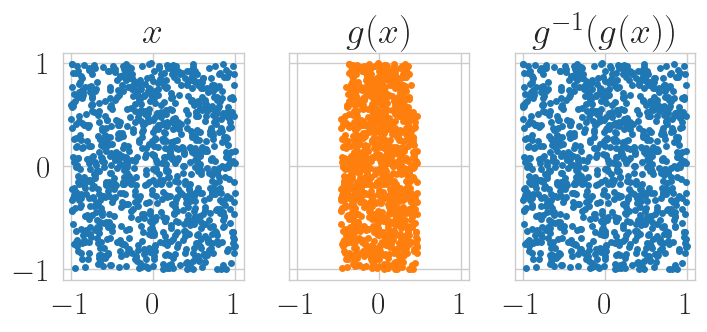

In [11]:
fig, ax = plt.subplots(1, 3, dpi=125, figsize=(6, 3), sharex=True, sharey=True)
np_gx, np_xp = grab(gx), grab(xp)
for a in ax:
    a.set_xlim(-1.1, 1.1)
    a.set_ylim(-1.1, 1.1)

ax[0].scatter(np_x[:, 0], np_x[:, 1], marker='.')
ax[0].set_title(r'$x$')

ax[1].scatter(np_gx[:, 0], np_gx[:, 1], marker='.', color='tab:orange')
ax[1].set_title(r'$g(x)$')

ax[2].scatter(np_xp[:, 0], np_xp[:, 1], marker='.')
ax[2].set_title(r'$g^{-1}(g(x))$')

fig.set_tight_layout(True)
plt.show()

In [12]:
# Composition
def apply_flow(prior, coupling_layers: list[CouplingLayer], *, batch_size: int):
    """
    Function to compose coupling layers by applying them sequentially to
    samples drawn from `prior`.

    Args:
        prior: Prior distribution
        coupling_layers: List of coupling layers
        batch_size: Number of samples drawn from prior

    Returns:
        Transformed samples and total log det Jacobian of transformation
    """
    x = prior.sample(batch_size)
    logq = prior.log_prob(x)
    for layer in coupling_layers:
        x, logJ = layer.forward(x)
        logq = logq - logJ
    return x, logq

# Part 3: Application to $\phi^4$ Scalar Field Theory on the Lattice

In [13]:
# Create a small 2 x 2 lattice
L = 8
Nd = 2
lattice_shape = (L,) * Nd

The action for a scalar field $\phi: \mathbb{R}^{1 + 1} \rightarrow \mathbb{R}$ with 4-point self-interaction is given by $S = \int {\rm d^2}x \; \mathscr{L}(\phi, \partial_mu \phi)$, with Lagrangian density
$$\mathcal{L} = \frac{1}{2} \partial_\mu \phi(x) \partial^\mu \phi(x) - \frac{1}{2}m^2 \phi(x)^2 + \frac{\lambda}{4} \phi^4(x).$$

The lattice (discretized) version of this action replaces spacetime gradients with finite differences, and continuum spacetime with discrete lattice sites $x_j \in \Lambda$:
$$S[\phi] = \sum_{\mu = 0}^{N_d - 1} a^2 \sum_{x \in \Lambda} \left\{\frac{1}{2}\left(\frac{\phi(x + a\hat{\mu}) - \phi(x)}{a}\right)^2 - \frac{1}{2}m^2 \phi(x)^2 + \frac{\lambda}{4} \phi^4(x)\right\},$$
which, upon integrating by parts and switching to units where the lattice spacing is unity, gives
$$S[\phi] = \sum_{\mu=0, 1} \sum_{x \in \Lambda} \left\{\phi(x) \left[-\phi(x + \hat{\mu}) + 2 \phi(x) - \phi(x - \hat{\mu})\right] - m^2 \phi^2(x) + \lambda \phi^4(x)\right\}$$

In [14]:
# Define the lattice action
class ScalarPhi4Action:
    def __init__(self, m2: float, lam: float):
        self.m2 = m2
        self.lam = lam

    def __call__(self, cfgs: torch.Tensor):
        """
        Computes the total action on a batch of field configs.
        
        Args:
            cfgs: Field configurations, shaped [batch_size, Lx, ...]

        Returns:
            Batch of action values as Lorentz scalars.
        """
        # Potential term
        action_density = self.m2 * cfgs**2 + self.lam * cfgs**4

        # Kinetic term
        Nd = len(cfgs.shape) - 1
        dims = range(1, Nd + 1)
        for mu in dims:
            laplacian = 2*cfgs - torch.roll(cfgs, -1, mu) - torch.roll(cfgs, 1, mu)
            action_density += cfgs * laplacian
        
        return torch.sum(action_density, dim=tuple(dims))  # integrate over spacetime
    

# Test it out!
def _test_action():
    # 2 random field configs
    phi = np.random.normal(size=(2, *lattice_shape)).astype(float_dtype)
    cfgs = torch.from_numpy(phi).to(torch_device)
    print("Action for example configs:", ScalarPhi4Action(m2=1.0, lam=1.0)(cfgs))

if __name__ == '__main__': _test_action()

Action for example configs: tensor([652.1395, 316.4578])


For this example we will focus on the symmetric phase, but we will stay close to the phase transition so that the system has a non-trivial correlation length.

In [15]:
# Set action parameters
m2 = -4.0
lam = 8.0
phi4_action = ScalarPhi4Action(m2=m2, lam=lam)

z.shape: (1024, 8, 8)


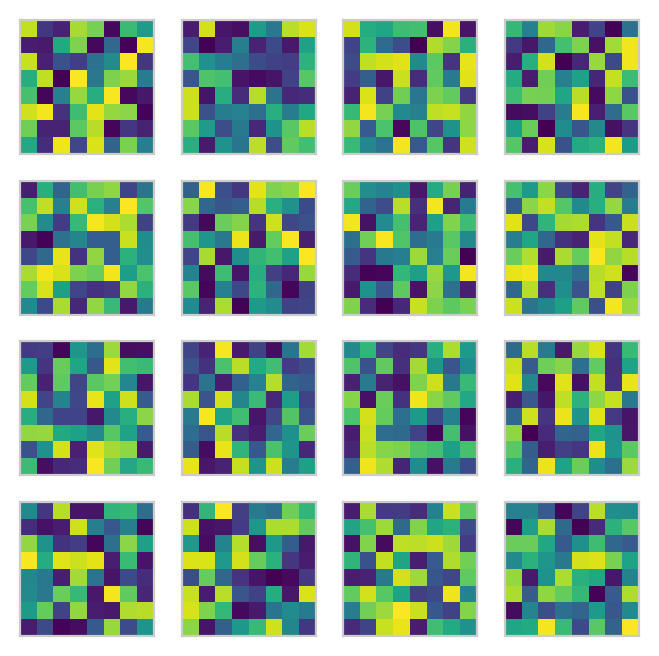

In [16]:
# Choose prior to give IID gaussians at each site on the lattice
prior = SimpleNormalPrior(torch.zeros(lattice_shape), torch.ones(lattice_shape))
torch_z = prior.sample(1024)
z = grab(torch_z)
print('z.shape:', z.shape)

# Visualize some samples drawn from the prior
fig, ax = plt.subplots(4, 4, dpi=200, figsize=(4, 4))
for i in range(4):
    for j in range(4):
        idx = i*4 + j
        ax[i, j].imshow(np.tanh(z[idx]), vmin=-1, vmax=1, cmap='viridis')
        ax[i, j].axes.xaxis.set_visible(False)
        ax[i, j].axes.yaxis.set_visible(False)
plt.show()  # should look like a bunch of uncorrelated, random nothingness

Since these are drawn from an IID prior, these uncorrelated lattices make sense. If they were samples from the true theory, we would expect to see patterns of correlated positive and negative fluctuations across the lattice.

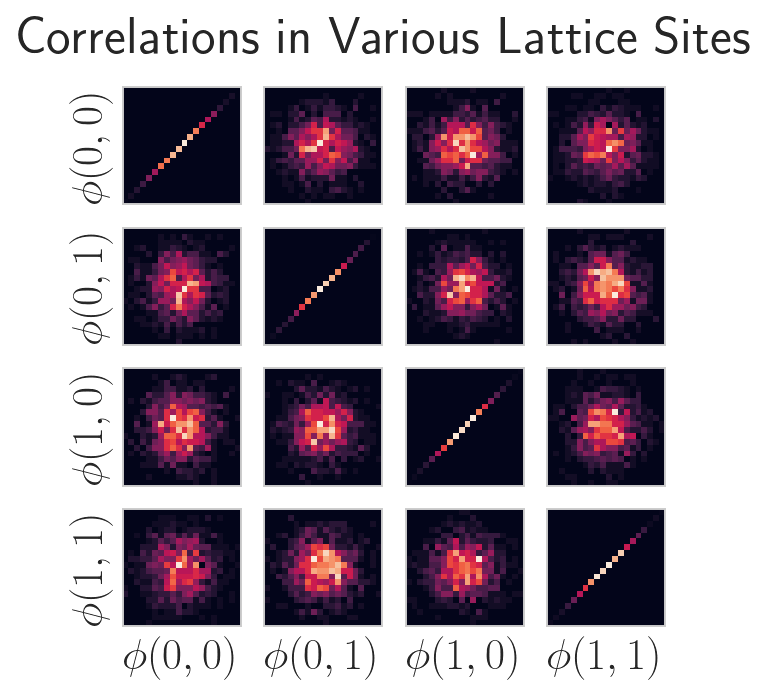

In [17]:
# Show two-way histograms between various sites, demonstrating the uncorrelated nature of the prior
fig, ax = plt.subplots(4,4, dpi=175, figsize=(4,4))
for x1 in range(2):
    for y1 in range(2):
        i1 = x1*2 + y1
        for x2 in range(2):
            for y2 in range(2):
                i2 = x2*2 + y2
                ax[i1,i2].hist2d(z[:,x1,y1], z[:,x2,y2], range=[[-3,3],[-3,3]], bins=20)
                ax[i1,i2].set_xticks([])
                ax[i1,i2].set_yticks([])
                if i1 == 3:
                    ax[i1,i2].set_xlabel(rf'$\phi({x2},{y2})$')
                if i2 == 0:
                    ax[i1,i2].set_ylabel(rf'$\phi({x1},{y1})$')
fig.suptitle("Correlations in Various Lattice Sites")
plt.show()

slope 1 linear regression S = -logr + 1455.4647


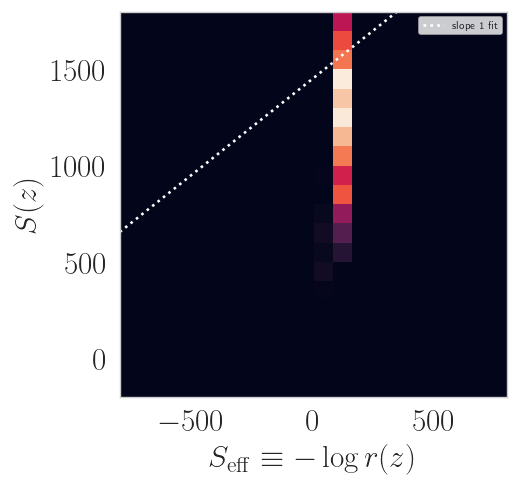

In [18]:
# Look at the correlation between the "effective action" $-\log r(z)$ defining the model distribution and the TRUE action $S(z)$
S_eff = -grab(prior.log_prob(torch_z))
S = grab(phi4_action(torch_z))
fit_b = np.mean(S) - np.mean(S_eff)
print(f'slope 1 linear regression S = -logr + {fit_b:.4f}')

fig, ax = plt.subplots(1, 1, dpi=125, figsize=(4, 4))
ax.hist2d(S_eff, S, bins=20, range=[[-800, 800], [-200, 1800]])
xs = np.linspace(-800, 800, num=4, endpoint=True)
ax.plot(xs, xs + fit_b, ':', color='w', label='slope 1 fit')
ax.set_xlabel(r'$S_{\mathrm{eff}} \equiv -\log r(z)$')
ax.set_ylabel(r'$S(z)$')
plt.legend(prop={'size': 6})
plt.show()

Since we haven't "flowed" anything yet, it makes sense that the log probabilities are not correlated.

## Idea: active & frozen variable updates for triangular jacobian
Affine transformation on active and frozen variables:
$$g(\phi_1, \phi_2) = \left(e^{s(\phi_2)}\phi_1 + t(\phi_2), \phi_2\right)$$

Inverse:
$$g^{-1}(\phi_1', \phi_2') = \left((\phi_1' - t(\phi_2'))e^{-s(\phi_2')}, \phi_2'\right)$$

In [19]:
# CHECKERBOARD MASKING 
# m(n) = 1 <=> field value on site n is frozen subset -> input to NN
def make_checker_mask(shape, parity):
    checker = torch.ones(shape, dtype=torch.uint8) - parity
    checker[::2, ::2] = parity
    checker[1::2, 1::2] = parity
    return checker.to(torch_device)

print('For example, this is the mask for an 8x8 configuration:\n', 
        make_checker_mask(lattice_shape, 0))

For example, this is the mask for an 8x8 configuration:
 tensor([[0, 1, 0, 1, 0, 1, 0, 1],
        [1, 0, 1, 0, 1, 0, 1, 0],
        [0, 1, 0, 1, 0, 1, 0, 1],
        [1, 0, 1, 0, 1, 0, 1, 0],
        [0, 1, 0, 1, 0, 1, 0, 1],
        [1, 0, 1, 0, 1, 0, 1, 0],
        [0, 1, 0, 1, 0, 1, 0, 1],
        [1, 0, 1, 0, 1, 0, 1, 0]], dtype=torch.uint8)


Some nice features of the coupling layer implementation:
- Parallelization: allow $s$ & $t$ channels to produce outputs for both active AND frozen subsets of field values, then just mask them out
- Simplicity: use the same NN to parameterize $s$ & $t$ so that parameters are shared

In [20]:
# Define the affine coupling layer
class AffineCoupling(CouplingLayer):
    """
    Affine coupling layer for flowing scalar field configurations.

    Transformation is defined by

        g(phi_1, phi_2) = [exp(s(phi_2)) * phi_1 + t(phi_2), phi_2]

    Args:
        net: Neural network used for both `s` and `t` channels of xform
        mask_shape: Tuple of lengths specifying size of mask; should be same as
            `lattice_shape`
        mask_parity: Whether even or odd mask

    Attributes:
        mask: Parity mask used to separate even and odd lattice sites
        net: Same as input `net`
    """
    def __init__(
        self, 
        net: torch.nn.Sequential, 
        *, 
        mask_shape: tuple[int], 
        mask_parity: bool
    ):
        super().__init__()

        self.mask = make_checker_mask(mask_shape, mask_parity)
        self.net = net
    
    def forward(self, x):
        x_frozen = self.mask * x
        x_active = (1 - self.mask) * x

        net_out = self.net(x_frozen.unsqueeze(1))  # fictitious `num_channels` dimension
        s, t = net_out[:, 0], net_out[:, 1]

        axes = range(1, len(s.size()))
        fx = (1 - self.mask)*t + x_active*torch.exp(s) + x_frozen
        logJ = torch.sum((1 - self.mask) * s, dim=tuple(axes))

        return fx, logJ
    
    def reverse(self, fx):
        fx_frozen = self.mask * fx
        fx_active = (1 - self.mask) * fx
        
        net_out = self.net(fx_frozen.unsqueeze(1))
        s, t = net_out[:, 0], net_out[:, 1]

        axes = range(1, len(s.size()))
        x = (fx_active - (1 - self.mask)*t) * torch.exp(-s) + fx_frozen
        logJ = torch.sum((1 - self.mask) * (-s), dim=tuple(axes))

        return x, logJ

## Choosing the architecture
How to choose what type of NN to parameterize the functions $s$ and $t$? 

We will use CNNs because they're relatively inexpensive...but more importantly, they manifestly embody a very important physical symmetry: spacetime translation!

More explicitly, CNNs are translation **equivariant**, and since parity-preserving translations are exact symmetries of our output distribution, building this into our networks will enforce this symmetry. CNNs also are equipped with periodic boundary conditions, which nicely matches the toroidal topology of our lattice.

In [21]:
# Basic CNN constructor
def make_conv_net(*, 
    hidden_sizes: list[int], 
    kernel_size: int, 
    in_channels: int, 
    out_channels: int, 
    use_final_tanh: t.Optional[bool] = True
) -> torch.nn.Sequential:
    """
    Constructs a simple CNN to be used inside coupling layer for `s` and `t`
    channels, incorporating activation functions that approximately preserve
    Z_2 symmetry. 

    Note: Bijectivity of flow ==> requires input and output shapes to be the
    same, so we use no pooling and a fixed stride of 1.
    """
    sizes = [in_channels] + hidden_sizes + [out_channels]

    assert kernel_size % 2 == 1; 'kernel size must be odd for PyTorch >= 1.5.0'
    padding_size = (kernel_size // 2)

    net = []
    for i in range(len(sizes) - 1):
        net.append(
            torch.nn.Conv2d(
                sizes[i], sizes[i+1], kernel_size, padding=padding_size,
                stride=1, padding_mode='circular'
            )
        )
        if i != len(sizes) - 2:
            net.append(torch.nn.LeakyReLU())
        else:
            if use_final_tanh:
                net.append(torch.nn.Tanh())
    return torch.nn.Sequential(*net)

## Assembling the model

In [22]:
# Compose coupling layers into a single flow function
def make_phi4_affine_layers(*, 
    num_layers: int, 
    lattice_shape: tuple[int], 
    hidden_sizes: int, 
    kernel_size: int
) -> torch.nn.ModuleList:
    """
    Assembles a sequence of coupling layers with alternating parity.
    """
    layers = []
    for i in range(num_layers):
        parity = i % 2
        net = make_conv_net(
            in_channels=1, out_channels=2,
            hidden_sizes=hidden_sizes, kernel_size=kernel_size
        )
        coupling = AffineCoupling(net, mask_shape=lattice_shape, mask_parity=parity)
        layers.append(coupling)
    return torch.nn.ModuleList(layers)

We will compose a sequence of 16 affine coupling layers with alternating checkerboard mask parity.

Note:
- The CNNs have a kernel size of $3 \times 3$ which is sufficiently small to condition on local information in each transformation; this allows the flow to progressively build up the local correlations in physical field configurations
- Each CNN has one input channel (the fields) and two output channels ($s$ and $t$).

In [23]:
# Create the coupling layers
num_layers = 16
hidden_sizes = [8, 8]  # number of intermediate channels in hidden layers
kernel_size = 3
layers = make_phi4_affine_layers(
    lattice_shape = lattice_shape,
    num_layers = num_layers,
    hidden_sizes = hidden_sizes,
    kernel_size = kernel_size
)

model = {
    'layers': layers,
    'prior': prior
}

## Training the Model
Flows are usually trained using the "forward" direction of the KL-divergence:
$$D_{KL}(p \| q) := \int d\phi \; p(\phi) \left[\log p(\phi) - \log q(\phi)\right]$$
which we can estimate with $N$ samples drawn from the target distribution *($\phi_i \sim p$) as
$$\hat{D}_{KL}(p \| q) = \frac{1}{N} \sum_{i=1}^N \left[\log p(\phi_i) - \log q (\phi_i)\right]$$
corresponding to the MLE with respect to training data from the true distribution.

But training data draw from the target distribution $p$ are scarce (or non-existent) in our context of lattice field theory simulations, so we instead make use of the **reverse** KL divergence:
$$D_{KL}(q \| p) = \int d\phi \; q(\phi) \left[\log q(\phi) - \log p(\phi)\right]$$
which we can similarly estimate using $N$ samples drawn from the model distribution ($\phi_i \sim q$) as
$$\hat{D}_{KL}(q \| p) = \frac{1}{N} \sum_{i=1}^N \left[ \log q(\phi_i) - \log p(\phi_i) \right]$$

In [24]:
def calc_kl_div(logp, logq):
    """Computes reverse KL-divergence, assuming samples from q."""
    return (logq - logp).mean()


def compute_ess(logp, logq):
    raise NotImplementedError('Will be defined later.')


def train_step(model, action, optimizer, metrics) -> None:
    """
    Executes a single training step, logging metrics for judging training
    training performance and model quality.
    """
    layers, prior = model['layers'], model['prior']
    optimizer.zero_grad()

    x, logq = apply_flow(prior, layers, batch_size=batch_size)
    logp = -action(x)
    loss = calc_kl_div(logp, logq)  # loss function
    loss.backward()
    optimizer.step()

    metrics['loss'].append(grab(loss))
    metrics['logp'].append(grab(logp))
    metrics['logq'].append(grab(logq))
    metrics['ess'].append(grab(compute_ess(logp, logq)))

## Telemetry
Measure some observables and diagnostics as we go.

For a batch of samples $\phi_i$, the effective sample size (ESS) is defined as
$$ESS = \frac{\left(\frac{1}{N}\sum_i p[\phi_i] / q[\phi_i] \right)^2}{\frac{1}{N}\sum_i \left(p[\phi_i] / q[\phi_i]\right)^2}$$
where $i$ indexes samples. This definition normalizes $ESS \in [0, 1]$. The ESS provides a useful measure of model quality that doesn't require overall normalization of $p(x)$, where larger values indicate a better effective sampling of the desired distribution and $ESS = $ indicates a perfect independent draw from the desired distribution for each sample. 

Why not use this directly to train? It's much noiser than the KL divergences, so in practice we find it's less effective as a loss function.

**Caution**: The ESS is biased towards larger values when estimated using small batches of samples. 

In [25]:
def compute_ess(logp, logq):
    """
    Computes the effective sample size per configuration given 
    log-probabilities of target (`logp`) and approximate (`logq`) densities.
    """
    logw = logp - logq
    log_ess = 2*torch.logsumexp(logw, dim=0) - torch.logsumexp(2*logw, dim=0)
    ess_per_cfg = torch.exp(log_ess) / len(logw)
    return ess_per_cfg


def print_metrics(era, epoch, history, avg_last_N_epochs) -> None:
    print(f'== Era {era} | Epoch {epoch} metrics ==')
    for key, val in history.items():
        avgd = np.mean(val[-avg_last_N_epochs:])
        print(f'\t{key}: {avgd:g}')

Now we can do the training!

In [26]:
# Physics / lattice params:
L = 8
Nd = 2
lattice_shape = (L,) * Nd
m2 = -4.0
lam = 8.0
phi4_action = ScalarPhi4Action(m2=m2, lam=lam)

# Model hyperparams
prior = SimpleNormalPrior(torch.zeros(lattice_shape), torch.ones(lattice_shape))
num_layers = 16
hidden_sizes = [8, 8]
kernel_size = 3

layers = make_phi4_affine_layers(
    lattice_shape = lattice_shape,
    num_layers = num_layers,
    hidden_sizes = hidden_sizes,
    kernel_size = kernel_size
)

model = {
    'layers': layers,
    'prior': prior
}

# Training hyperparams
use_pretrained: bool = False
base_lr: float = 1e-3
optimizer = torch.optim.Adam(
    params = model['layers'].parameters(), 
    lr = base_lr
)

num_eras: int = 25
num_epochs: int = 100
batch_size: int = 64
print_freq: int = num_epochs
plot_freq: int = 1

Skipping pre-trained model


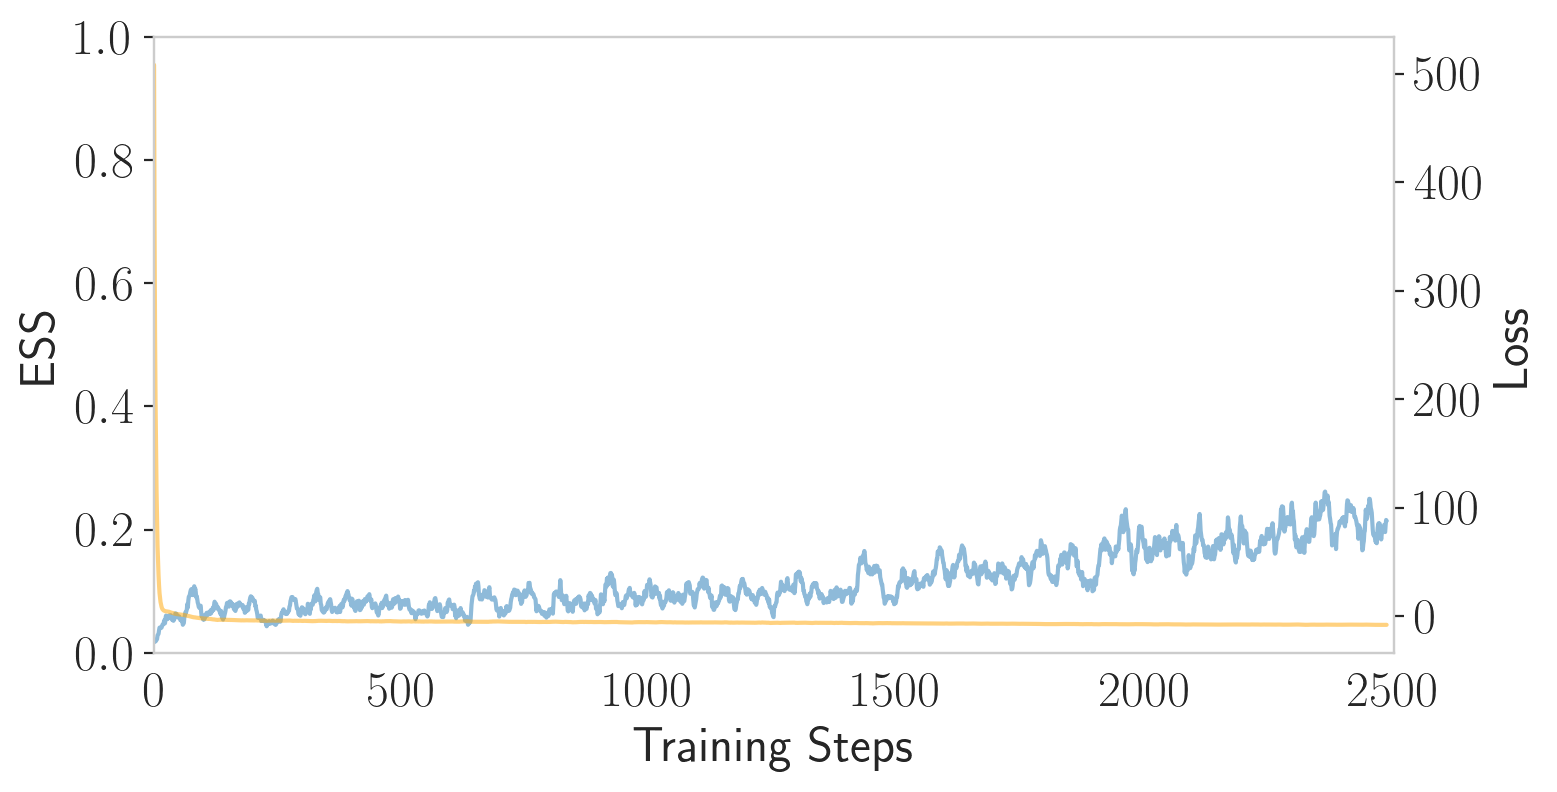

== Era 0 | Epoch 0 metrics ==
	loss: 2239.26
	logp: -2324.63
	logq: -85.3729
	ess: 0.015625
== Era 1 | Epoch 0 metrics ==
	loss: 55.9363
	logp: -66.4595
	logq: -10.5233
	ess: 0.0596619
== Era 2 | Epoch 0 metrics ==
	loss: -3.25106
	logp: -12.6339
	logq: -15.885
	ess: 0.0700543
== Era 3 | Epoch 0 metrics ==
	loss: -4.13139
	logp: -12.5976
	logq: -16.729
	ess: 0.0643392
== Era 4 | Epoch 0 metrics ==
	loss: -4.45401
	logp: -12.4943
	logq: -16.9483
	ess: 0.0773558
== Era 5 | Epoch 0 metrics ==
	loss: -4.6879
	logp: -12.5961
	logq: -17.284
	ess: 0.0804456
== Era 6 | Epoch 0 metrics ==
	loss: -4.94291
	logp: -12.5161
	logq: -17.4591
	ess: 0.0707823
== Era 7 | Epoch 0 metrics ==
	loss: -5.03243
	logp: -12.4835
	logq: -17.5159
	ess: 0.0810539
== Era 8 | Epoch 0 metrics ==
	loss: -5.2261
	logp: -12.4394
	logq: -17.6655
	ess: 0.0815118
== Era 9 | Epoch 0 metrics ==
	loss: -5.37402
	logp: -12.3307
	logq: -17.7047
	ess: 0.082268
== Era 10 | Epoch 0 metrics ==
	loss: -5.52867
	logp: -12.353
	logq: 

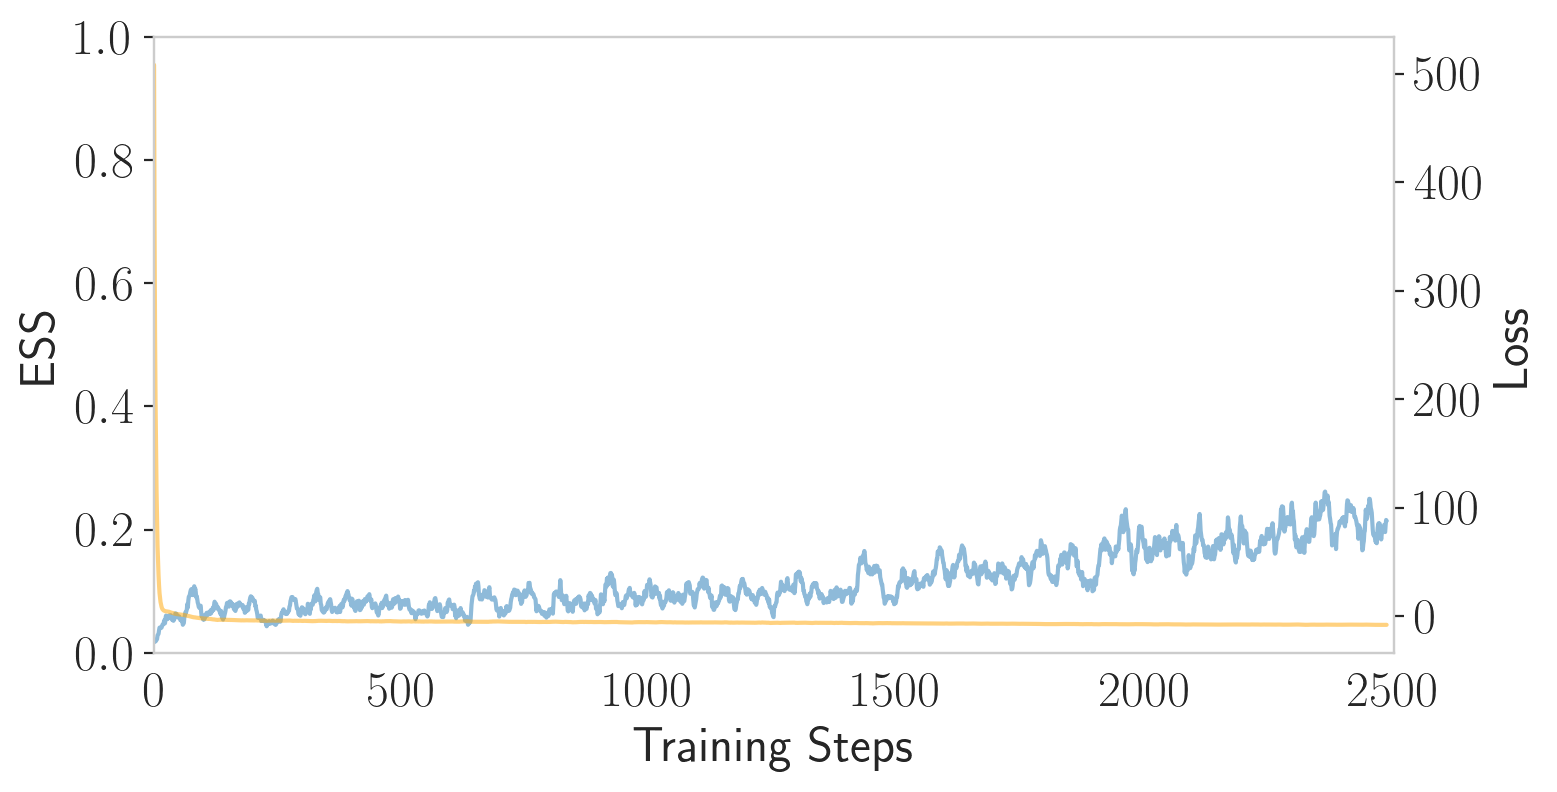

In [27]:
# Training setup
if use_pretrained:
    print('Loading pre-trained model')
    phi4_trained_weights = torch.load(
        io.BytesIO(
            base64.b64decode(b"""<snipped base64 blob>""".strip())
        ), 
        map_location=torch.device('cpu')
    )
    model['layers'].load_state_dict(phi4_trained_weights)
    if torch_device == 'cuda':
        model['layers'].cuda()
else:
    print('Skipping pre-trained model')

history = {
    'loss': [],
    'logp': [],
    'logq': [],
    'ess': []
}

if not use_pretrained:
    # Close all existing figures
    [plt.close(plt.figure(fignum)) for fignum in plt.get_fignums()]
    live_plot = TrainingPlot(num_eras, num_epochs)

    # Training loop
    for era in range(num_eras):
        for epoch in range(num_epochs):
            train_step(model, phi4_action, optimizer, history)

            if epoch % print_freq == 0:
                print_metrics(era, epoch, history, avg_last_N_epochs=print_freq)

            if epoch % plot_freq == 0:
                live_plot.update(history, **live_plot.fig_dict)
else:
    print('Skipping training')

print('Model weights blob:\n===')
serialized_model = io.BytesIO()
torch.save(model['layers'].state_dict(), serialized_model)
print(base64.b64encode(serialized_model.getbuffer()).decode('utf-8'))
print('===')

## Evaluating the Model
- draw samples directly from prior, $z \sim r(z)$
- 'flow' them using trained model, $\phi = f(z) \sim q(f^{-1}(z))$
- visualize their quality

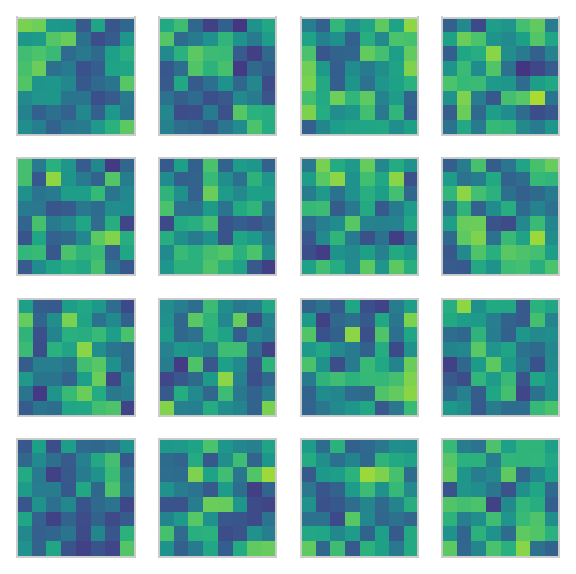

In [28]:
torch_x, torch_logq = apply_flow(prior, layers, batch_size=1024)
x = grab(torch_x)

fig, ax = plt.subplots(4, 4, dpi=175, figsize=(4, 4))
for i in range(4):
    for j in range(4):
        ind = i*4 + j
        ax[i, j].imshow(np.tanh(x[ind]), vmin=-1, vmax=1, cmap='viridis')
        ax[i, j].axes.xaxis.set_visible(False)
        ax[i, j].axes.yaxis.set_visible(False)
plt.show()

slope 1 linear regression S = S_eff + -7.9504


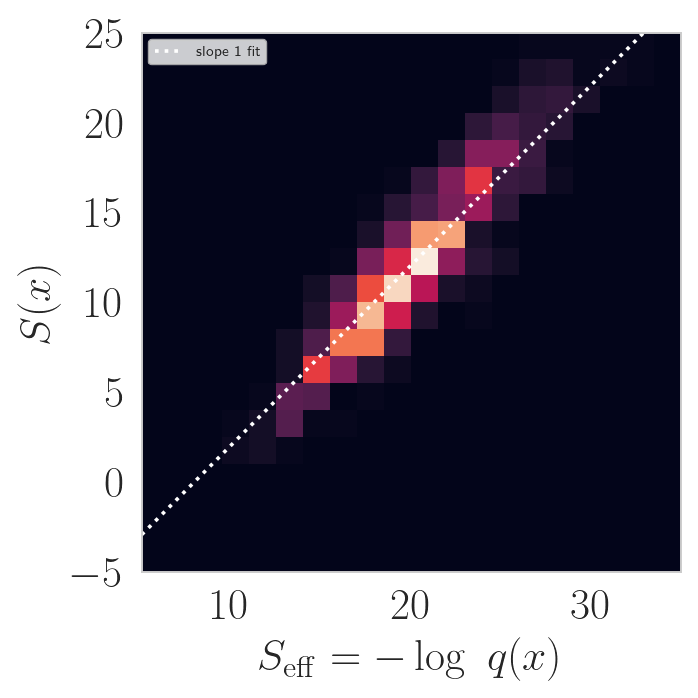

In [29]:
# Look at correlation between true action and effective action
S_eff = -grab(torch_logq)
S = grab(phi4_action(torch_x))

fit_b = np.mean(S) - np.mean(S_eff)
print(f'slope 1 linear regression S = S_eff + {fit_b:.4f}')

fig, ax = plt.subplots(1,1, dpi=175, figsize=(4,4))
ax.hist2d(S_eff, S, bins=20, range=[[5, 35], [-5, 25]])
ax.set_xlabel(r'$S_{\mathrm{eff}} = -\log~q(x)$')
ax.set_ylabel(r'$S(x)$')
ax.set_aspect('equal')
xs = np.linspace(5, 35, num=4, endpoint=True)
ax.plot(xs, xs + fit_b, ':', color='w', label='slope 1 fit')
plt.legend(prop={'size': 6})
plt.show()

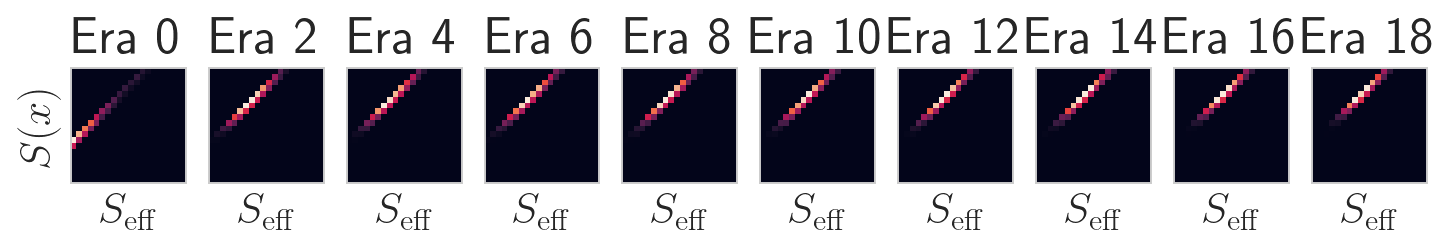

In [30]:
# See how model density evolved over training time to become closer to p(x)
if not use_pretrained:
    logq_hist = np.array(history['logq']).reshape(num_eras, -1)[::num_eras//10]
    logp_hist = np.array(history['logp']).reshape(num_eras, -1)[::num_eras//10]
    
    fig, axes = plt.subplots(1, 10, dpi=175, sharey=True, figsize=(10, 1))
    for i, (ax, logq, logp) in enumerate(zip(axes, logq_hist, logq_hist)):
        ax.hist2d(-logq, -logp, bins=20, range=[[5, 35], [-5, 25]])
        if i == 0:
            ax.set_ylabel(r'$S(x)$')
        ax.set_xlabel(r'$S_{\mathrm{eff}}$')
        ax.set_title(f'Era {i * (num_eras//10)}')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_aspect('equal')
    plt.show()

## Independence Metropolis
- We ultimately need **unbiased** estimates of observables, which can be achieved either by reweighting or resampling according to the weights $p(\phi_i) / q(\phi_i)$. 
- One of many resampling approaches is to use the model samples as proposals in a MCMC
- Use metropolis hastings algo to construct the asymptotically exact MC sampler, but use a modification where the transition probabilities are independent of previous configuration, i.e. 

$$T(x \to y) = T(y) = q(y)$$

In [31]:
def _serial_sample_generator(model, action, batch_size, num_samples) -> t.Generator:
    """
    Generates an ordered list of samples using the trained `model` by drawing
    batches of size `batch_size` from the prior in parallel, and feeding them 
    through the flow function iteratively.
    """
    layers, prior = model['layers'], model['prior']
    layers.eval()

    x, logq, logp = None, None, None
    for i in range(num_samples):
        batch_i = i % batch_size
        if batch_i == 0:
            # Out of samples to propose; generate a new batch
            x, logq = apply_flow(prior, layers, batch_size=batch_size)
            logp = -action(x)
        yield x[batch_i], logq[batch_i], logp[batch_i]


def make_mcmc_ensemble(model, action, batch_size, num_samples) -> dict[str: torch.Tensor]:
    """
    Iterates over generated samples to construct them into a Markov Chain, then
    implements a Metropolis independence sampler.
    """
    history = {
        'x': [],
        'logq': [],
        'logp': [],
        'accepted': []
    }

    # Build Markov chain
    sample_gen = _serial_sample_generator(model, action, batch_size, num_samples)
    for new_x, new_logq, new_logp in sample_gen:
        if len(history['logp']) == 0:
            # Always accept first proposal
            accepted = True
        else:
            # Metropolis acceptance condition
            last_logp = history['logp'][-1]
            last_logq = history['logq'][-1]
            p_accept = torch.exp((new_logp - new_logq) - (last_logp - last_logq))
            p_accept = min(1, p_accept)
            draw = torch.rand(1)  # ~ [0, 1]
            if draw < p_accept:
                accepted = True
            else:
                accepted = False
                new_x = history['x'][-1]
                new_logp = last_logp
                new_logq = last_logq
        # Update Markov chain
        history['logp'].append(new_logp)
        history['logq'].append(new_logq)
        history['x'].append(new_x)
        history['accepted'].append(accepted)
    return history

In [32]:
# Generate Ensemble
ensemble_size = 8192
phi4_ens = make_mcmc_ensemble(model, phi4_action, 64, ensemble_size)
print('Acceptance rate:', np.mean(phi4_ens['accepted']))

Acceptance rate: 0.2662353515625


Now let's compute some physical observables, and compare against values determined from large HMC ensembles evaluated at the same physical parameters

In [33]:
def two_point_susceptibility(cfgs):
    """
    Computes the two-point susceptibility on a batch of configs, assuming the
    lattice is two-dimensional.
    """
    C = 0
    for x in range(L):
        for y in range(L):
            C = C + cfgs * np.roll(cfgs, (-x, -y), axis=(1, 2))
    X = np.mean(C, axis=(1, 2))
    return X


def bootstrap(x, *, num_boots, binsize) -> tuple[float, float]:
    """
    Performs the statistical bootstrap on a batch of observables, employing
    binning to reliably estimate errors despite potential autocorrelations in
    data.
    """
    boots = []
    x = x.reshape(-1, binsize, *x.shape[1:])
    for _ in range(num_boots):
        # Binning
        boot = np.mean(x[np.random.randint(len(x), size=len(x))], axis=(0, 1))
        boots.append(boot)
    return np.mean(boots), np.std(boots)

In [34]:
num_therm = 512
cfgs = np.stack(list(map(grab, phi4_ens['x'])), axis=0)[num_therm:]
X = two_point_susceptibility(cfgs)
X_mean, X_err = bootstrap(X, num_boots=100, binsize=4)
print(f'Two-point susceptibility = {X_mean:.2f} +/- {X_err:.2f}')
print(f'... vs HMC estimate = 0.75 +/- 0.01')

Two-point susceptibility = 0.63 +/- 0.02
... vs HMC estimate = 0.75 +/- 0.01
